Author : [RODANI Yassine](https://www.linkedin.com/in/yassine-rodani-420b99202/)

# Abstract

From a human perspective, birds vary in appearance in terms of shape, size, color and other factors. The most effective approach to recognizing birds is to understand them through photographs.

In this work, we first propose to establish a first deep learning model to predict bird classes using the Keras library. Then, we will set a second pre-trained model based on the VGG16 architecture, to which we will add some optimization layers.




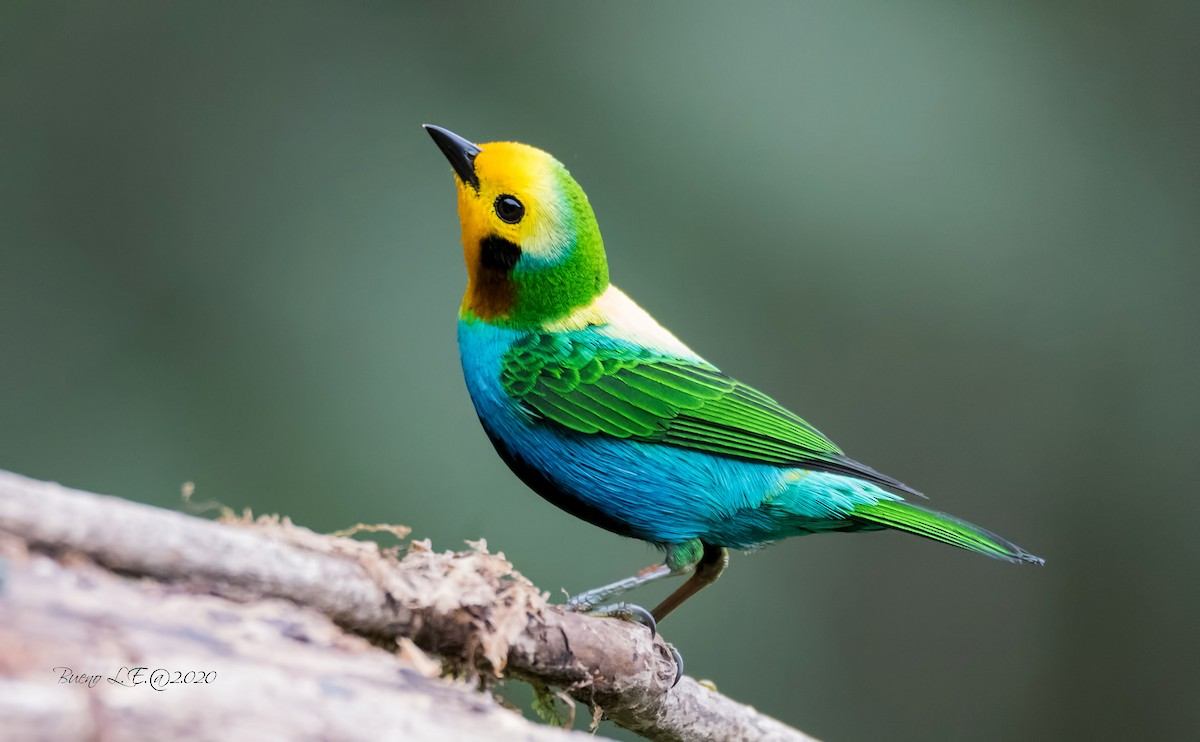
Source : Dearborn

# Importing Libraries

### For initial data exploration

In [ ]:
import os
import glob
import pathlib
import pandas as pd
import numpy as np
import random

### For modeling and model viewing

In [ ]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16

# Data Pre-processing

## Data Overview

[BIRDS 400](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) is a dataset of 400 bird species. 58388 training images, 2000 test images (5 images per species) and 2000 validation images (5 images per species).

This is a very high-quality dataset with only one bird in each image, and the bird typically takes up at least 50% of the pixels in the picture. As a result, even a moderately complex model will achieve training and test accuracies in the mid-80 % range. All images are 224 X 224 X 3 color images in jpg format. The data set includes a train set, test set, and validation set. Each set contains 400 subdirectories, one for each bird species.

In our case, we have chosen the first 100 classes among the 400 in the database to speed up our models' learning process.

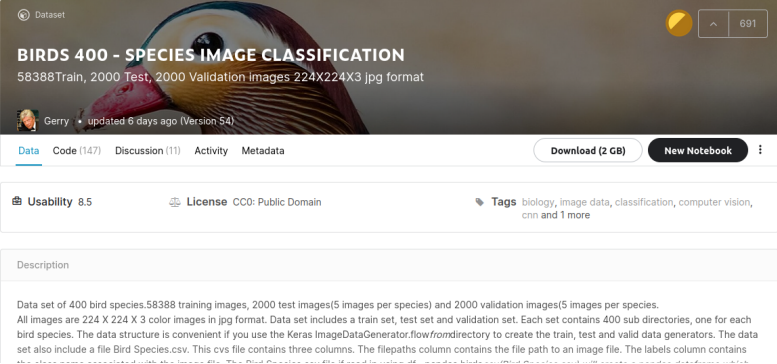

Source: Kaggle

This will set up paths to our main directories

In [ ]:
DIR_BASE = ('/content/drive/MyDrive/test_db_100')
DIR_TRAIN = os.path.join(DIR_BASE, 'train')
DIR_VALID = os.path.join(DIR_BASE, 'valid')
DIR_TEST = os.path.join(DIR_BASE, 'test')

# Defining a function that creates a pandas.DataFrame containing the bird classes label

In [ ]:
def process(data):

    """
    Takes the directory as input and returns a panda DataFrame that contains our classe's labels.
    """
    path=pathlib.Path(data) # Converting String data to a Path data
    filepaths=list(path.glob(r"*/*.jpg"))
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths)) # Separating labels from filepaths and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1) # Building the Dataframe
    return df

In [ ]:
df_train=process(DIR_TRAIN)
df_valid=process(DIR_VALID)
df_test=process(DIR_TEST)

In [ ]:
df_train.head()

filepaths            labels
0  /content/drive/MyDrive/test_db_100/train/CAPE ...  CAPE MAY WARBLER
1  /content/drive/MyDrive/test_db_100/train/CAPE ...  CAPE MAY WARBLER
2  /content/drive/MyDrive/test_db_100/train/CAPE ...  CAPE MAY WARBLER
3  /content/drive/MyDrive/test_db_100/train/CAPE ...  CAPE MAY WARBLER
4  /content/drive/MyDrive/test_db_100/train/CAPE ...  CAPE MAY WARBLER

Storing the previously created DataFrame in a CSV file

In [ ]:
filepath = pathlib.Path('/content/drive/MyDrive/test_db_100/dataframe.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train.to_csv(filepath)  

### Defining a function that displays a graph representing the number of images per bird class in a directory

In [ ]:
def calc_labels(dir):
    cnts, labels = {}, []
    for label in sorted(os.listdir(f'{dir}')):
        labels.append(label)
        cnts[label] = len(os.listdir(f'{dir}/{label}/'))
    return cnts, labels

def plot_classes_graph(dir):

    """ 
    takes the directory as input and displays a graph representing the number of images per bird's class in a directory.
    """

    labels_count = calc_labels(dir)[0]
    x, y = zip(*sorted(labels_count.items(), key = lambda e: e[0]))
    plt.figure(figsize=(25,5))
    plt.title('Nombre d\' images par classe d\'oiseaux dans le dossier train')
    plt.xlabel('Classe d\'oiseaux')
    plt.ylabel('Nombre d\'images')
    plt.plot(x, y, linewidth=1.5, label='Nombre d\' images par classe d\'oiseaux')
    plt.xticks(x, rotation=90)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.5)
    plt.show()

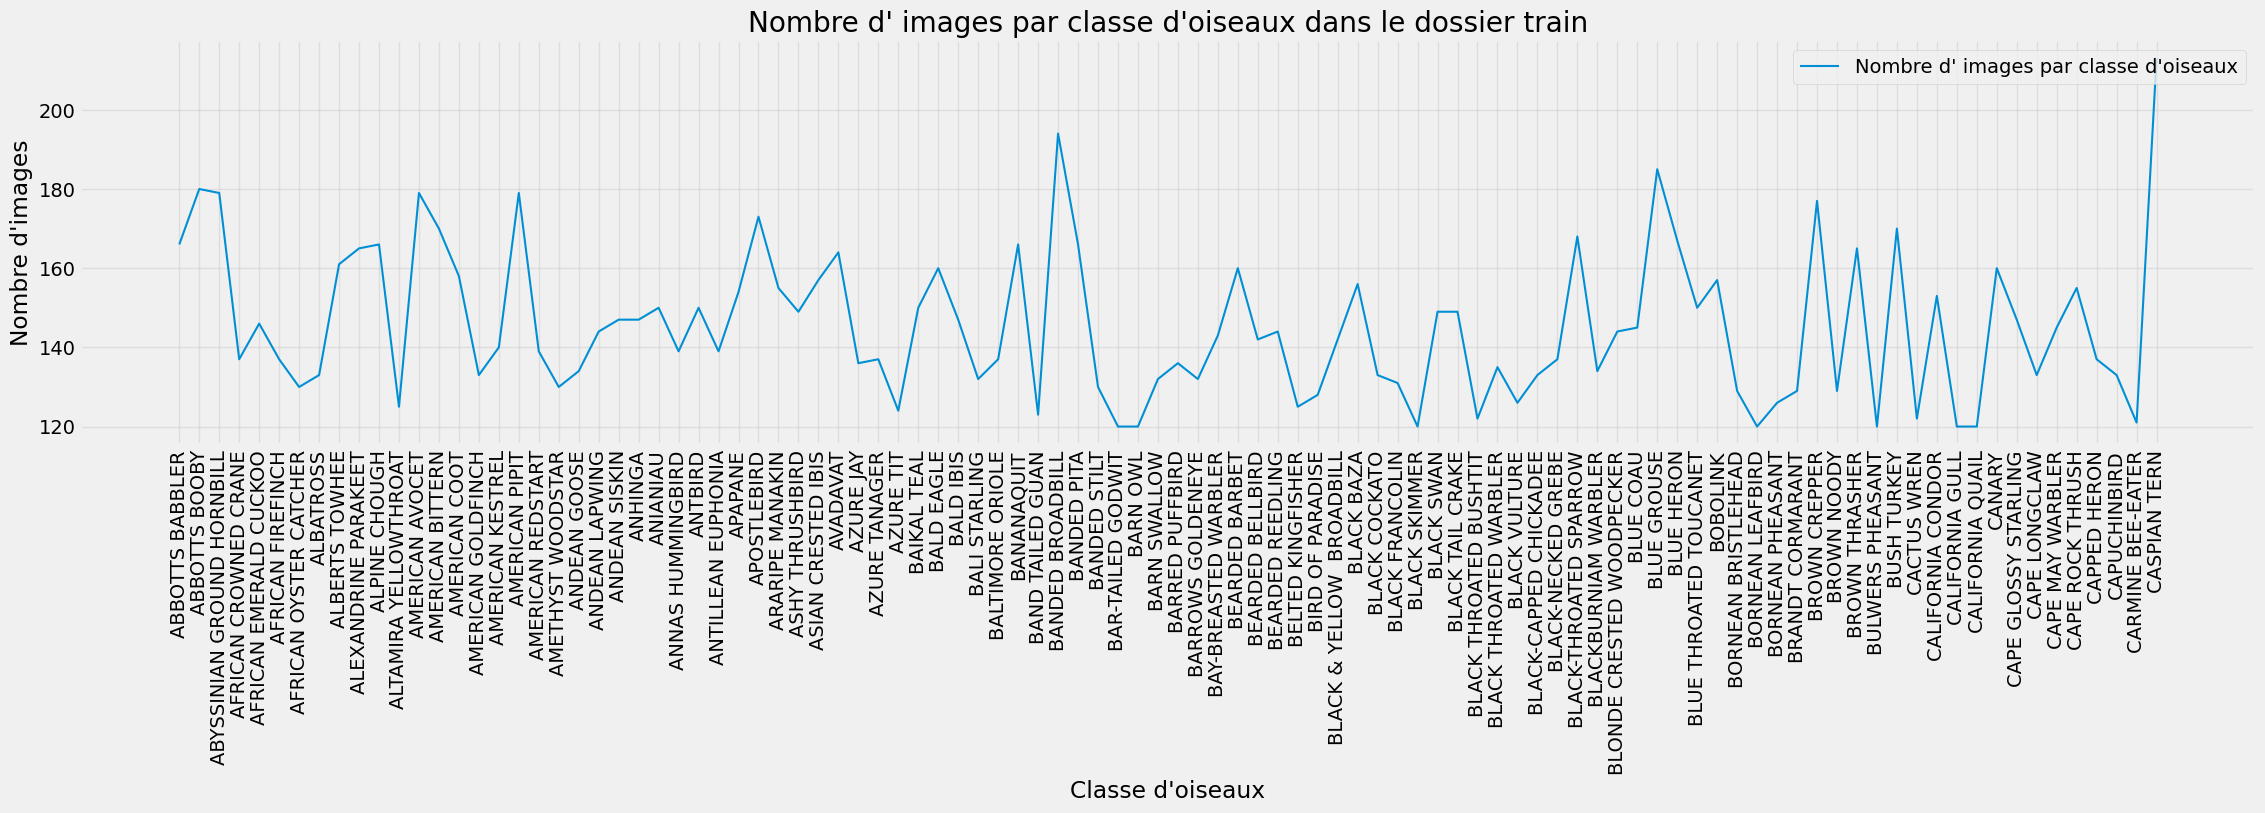

In [ ]:
plt.style.use('fivethirtyeight')
plot_classes_graph(DIR_TRAIN)
plt.style.use('default')

### Defining a function that randomly displays 6 images of different bird classes

In [ ]:
def plot_random_image_from_directory(target_dir):
  
    """ 
    takes the directory as input and displays 6 random images from the targeted directory.
    """

    target_dir=target_dir.sample(frac=1).reset_index(drop=True)
    fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(10, 10))

    for i,ax in enumerate(axes.flat): 
        x=plt.imread(target_dir['filepaths'][i])
        ax.imshow(x)
        ax.set_title(target_dir['labels'][i])
        ax.axis(False)
    plt.tight_layout()    
    plt.show() 

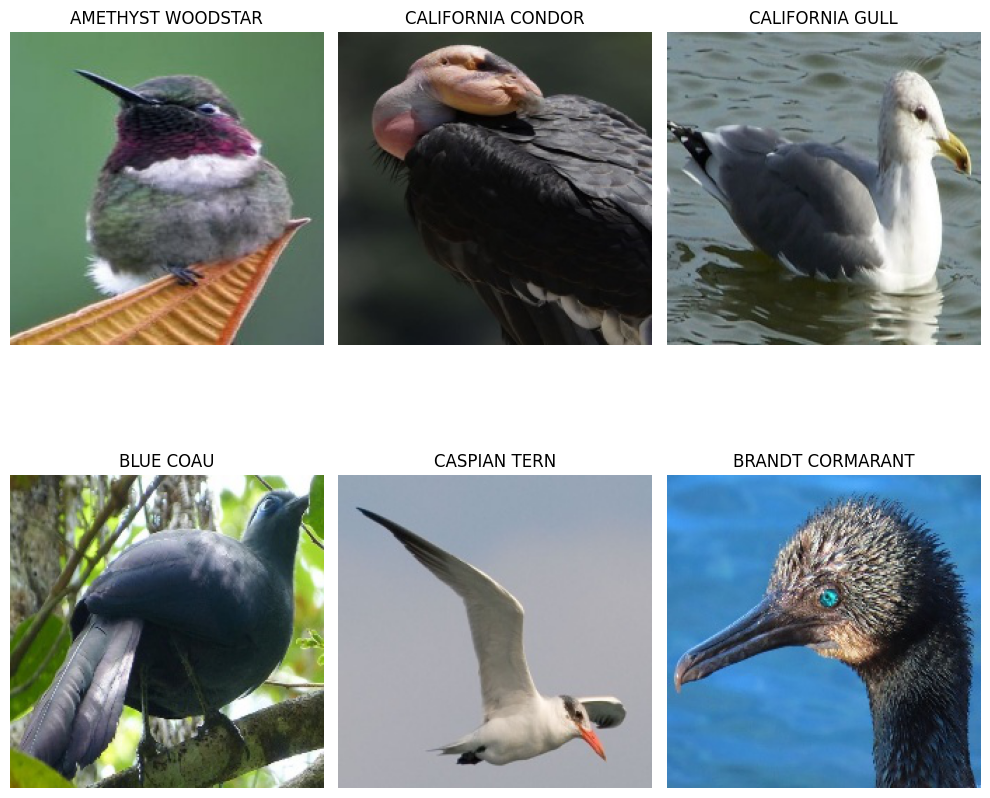

In [ ]:
plot_random_image_from_directory(df_train)

## Image Data Pre-processing

Keras data generator can be used to pass the images through the convolutional neural network and apply rotation and zoom transformations to the images if desired.

You can check https://keras.io/preprocessing/image/ for more transformations

In [ ]:
generator = ImageDataGenerator()

Generating batches of tensor image data with real-time data augmentation

In [ ]:
train_ds=generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=64,
    subset='training',
    random_seed=42)

valid_ds=generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32,
    subset='training')

test_ds = generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32)

Found 14486 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


Defining bird classes

In [ ]:
classes = list(train_ds.class_indices.keys())

In [ ]:
classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'AVADAVAT',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BAND TAILED GUAN',
 'BANDED BROADBILL',
 'BANDED PITA',
 'BANDED STILT',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BARROWS GOLDENEYE',
 'BAY-B

# First Model

## CNN Architecture

[CNNs](https://www.ibm.com/cloud/learn/convolutional-neural-networks) are a class of deep neural networks capable of recognizing and classifying particular features in images and are primarily used for image analysis.

The term "[convolution](https://en.wikipedia.org/wiki/Convolution)" in CNN refers to the mathematical function of convolution, a special linear operation in which two functions are multiplied to produce a third. The latter expresses how the form of one function is modified by the other.
In other words, two images that can be represented as matrices are multiplied to produce one that will be used to extract the features of the image in question.

There are two main parts in a CNN architecture:



*   A convolution tool that separates and identifies the different features of the image for analysis in a process called [Feature Extraction](https://en.wikipedia.org/wiki/Feature_extraction).

*   A [fully connected layer](https://iq.opengenus.org/fully-connected-layer/) that uses the convolution process's output and predicts the image's class based on the features extracted in the previous steps.

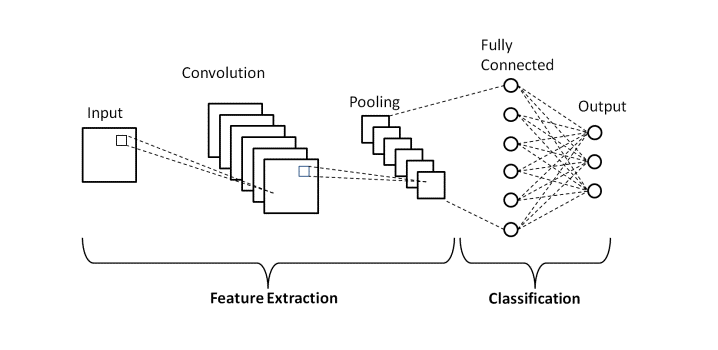


The CNN architecture proposed below gave significantly better results than the others.

It consists of four blocks :


*   The first block with two convolutional layers followed by a max pooling
*   A second one with two convolutional layers followed by max pooling
*   The third block with two convolutional layers followed by a max pooling and a normalization
*   The last one is made of a flattening layer, a 30% dropout, and two activation layers with ReLU and softmax functions



In [ ]:
model = Sequential()

# Bloc 1
model.add(Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (224,224,3)))
model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3)))

# Bloc 2
model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3)))

# Bloc 3
model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(BatchNormalization())

# Bloc 4
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

## Establishing the model

Defining where to save the model after each epoch.

In [ ]:
filepath = "/content/drive/MyDrive/test_db_100/my_model_100.h5"

Adding a criteria to save only if there has been an improvement of the model compared to the previous epoch (in this case, the model is saved if ***val_loss*** decreases).

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

We stop the training if there is no improvement in ***val_accuracy*** after 3 consecutive epochs.

In [ ]:
early_stopping_monitor = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)

callbacks_list = [checkpoint, early_stopping_monitor]

In this work, we propose to compile the training model using the Adam optimizer in Keras because:


* It converges at the end
* It learns faster than other optimizers
* It is more stable and does not suffer a significant drop in accuracy.

We also chose a value of 0.001 (the default value) for the learning_rate hyper-parameter because, after several tests with different values (0.0001; 0.01; 0.005), a learning rate of 0.001 gives better results for our model.

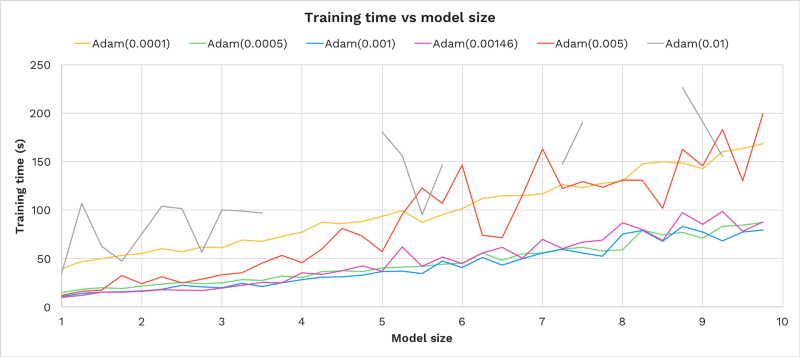

Choosing the cost function to optimize (Categorical Cross-Entropy)

In [ ]:
cost_function = keras.losses.categorical_crossentropy

Compiling the model by indicating that we also want to measure the accuracy and pass Adam as an optimizer with a default learning rate (0.001)

In [ ]:
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'adam', metrics = ["accuracy"])

We train the model by specifying it to use our validation set ***valid_ds*** to validate the hyper-parameters

In [ ]:
history = model.fit(train_ds,epochs=40, verbose=1, validation_data = valid_ds, batch_size=32, callbacks=[callbacks_list])

Epoch 1/40
227/227 [==============================] - 8761s 39s/step - loss: 4.9532 - accuracy: 0.0321 - val_loss: 4.6681 - val_accuracy: 0.0480
Epoch 2/40
227/227 [==============================] - 48s 212ms/step - loss: 4.1528 - accuracy: 0.1067 - val_loss: 3.9019 - val_accuracy: 0.1660
Epoch 3/40
227/227 [==============================] - 47s 208ms/step - loss: 3.3516 - accuracy: 0.2530 - val_loss: 3.8220 - val_accuracy: 0.2400
Epoch 4/40
227/227 [==============================] - 47s 206ms/step - loss: 2.7930 - accuracy: 0.3895 - val_loss: 2.9097 - val_accuracy: 0.3940
Epoch 5/40
227/227 [==============================] - 47s 205ms/step - loss: 2.4284 - accuracy: 0.5075 - val_loss: 2.7246 - val_accuracy: 0.4760
Epoch 6/40
227/227 [==============================] - 47s 207ms/step - loss: 2.1284 - accuracy: 0.6047 - val_loss: 2.3783 - val_accuracy: 0.5700
Epoch 7/40
227/227 [==============================] - 48s 210ms/step - loss: 1.8629 - accuracy: 0.7069 - val_loss: 2.2061 - val_ac

Evaluating the model on our test set ***test_ds***

In [ ]:
model.evaluate(test_ds,use_multiprocessing=True,workers=10)

16/16 [==============================] - 39s 3s/step - loss: 2.2749 - accuracy: 0.7440


[2.2749390602111816, 0.7440000176429749]

Saving the model

In [ ]:
model.save('/content/drive/MyDrive/test_db_100/my_model_100_96_74.h5')

## Performances review

### Defining a function that traces the variation of the accuracy on the train and the validation set according to the number of epochs

In [ ]:
def plot_acc(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))

  # Plot: accuracy vs epoch
  plt.figure(figsize=(15,3))
  plt.plot(epochs, acc,label='Training accuracy', linewidth=1.5)
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy', linewidth=1.5)
  plt.title('Training accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.figure()
  plt.show()

### Defining a function that traces the variation of the error rate on the train and the validation set according to the number of epochs

In [ ]:
def plot_loss(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  # Plot: loss values vs epoch
  plt.figure(figsize=(15,3))
  plt.plot(epochs, loss,label='Training loss', linewidth=1.5)
  plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=1.5)
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.figure()
  plt.show()

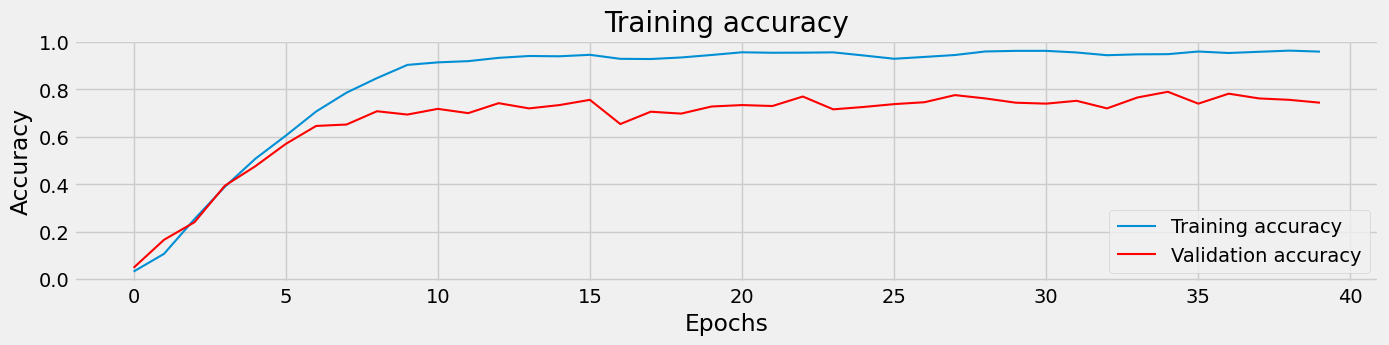

<Figure size 640x480 with 0 Axes>

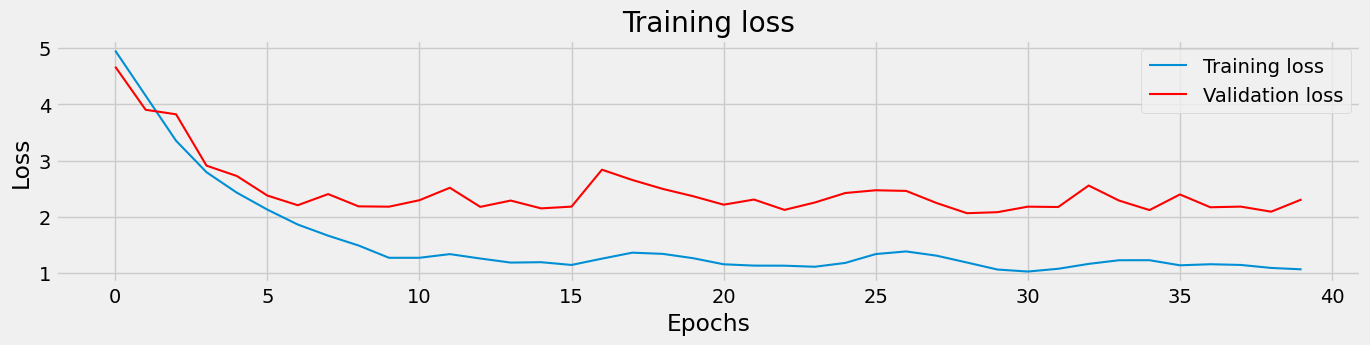

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.style.use('fivethirtyeight')
plot_acc(history)
plot_loss(history)
plt.style.use('default')

# Second Model

We propose a second model based on the VGG16 architecture.

## VGG-16 model overview

The base model used in this analysis is a pre-trained VGG16 neural network. This network is trained on an ImageNet dataset of over 14 million images. For convenience, the size of the images used in VGG16 is the same as the images used in this analysis: 224x224. VGG16 uses 5 blocks of 2D convolutional layers and 2D Max Pooling.

Here is a visual description of the VGG16 model:
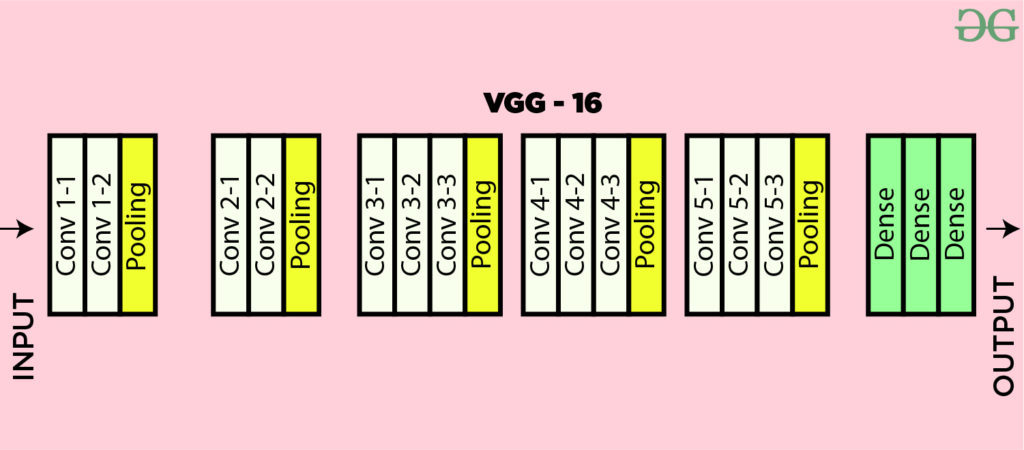

## Model Optimization

**Augmentation**

Data is augmented in several ways, such as rotating, zooming, and flipping horizontally. This allows the model to receive more images for training to have higher accuracy without the need for all new data sources.

**Change of architecture**

After freezing the layers of the base model, we added an applause layer and 3 activation layers. We also tested adding additional layers for batch normalization and 2D convolution, but they negatively affected performance.

### Data Augmentation
<ul><li>Randomly rotating the images by 40 degrees.</li><li>Shifting the image horizontally by 20%.</li><li>Shifting the image vertically by 20%.</li><li>Zooming the image by 20%.</li><li>Flipping the image horizontally.</li></ul>


In [ ]:
improved_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest') 


test_gen = ImageDataGenerator(rescale=1./255) 

improved_train_ds = improved_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=64,
    subset='training',
    random_seed=42)


improved_valid_ds = improved_gen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32)

improved_test_ds = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

Found 14486 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [ ]:
classes = list(improved_train_ds.class_indices.keys())

## Establishing the model

Loading the pre-trained model from keras

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model.trainable = False

for layer in vgg_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdfcdd3b590> False
<keras.layers.convolutional.Conv2D object at 0x7fdfcdb1eb10> False
<keras.layers.convolutional.Conv2D object at 0x7fdfcda99650> False
<keras.layers.pooling.MaxPooling2D object at 0x7fdf4a18b110> False
<keras.layers.convolutional.Conv2D object at 0x7fdfc790f8d0> False
<keras.layers.convolutional.Conv2D object at 0x7fdf4a18e790> False
<keras.layers.pooling.MaxPooling2D object at 0x7fdf4a195b90> False
<keras.layers.convolutional.Conv2D object at 0x7fdf4a19bfd0> False
<keras.layers.convolutional.Conv2D object at 0x7fdf4a1954d0> False
<keras.layers.convolutional.Conv2D object at 0x7fdf4a124510> False
<keras.layers.pooling.MaxPooling2D object at 0x7fdf4a12b650> False
<keras.layers.convolutional.Conv2D object at 0x7fdf4a126790> False
<keras.layers.convolutional.Conv2D object at 0x7fdf4a12f290> False
<keras.layers.convolutional.Conv2D object at 0x7fdf4a139750> False
<keras.layers.pooling.MaxPooling2D object at 0x7fdf4a13ddd0>

Adding a flattening layer and 3 dense layers, using Relu and Softmax as activation functions.

In [ ]:
layer0 = tf.keras.layers.Flatten()(vgg_model.output)
layer1 = tf.keras.layers.Dense(4096, activation='relu')(layer0)
layer2 = tf.keras.layers.Dense(4096, activation='relu')(layer1)
out_layer = tf.keras.layers.Dense(100, activation='softmax')(layer2)

Grouping the layers of our model and displaying a summary of its architecture.

In [ ]:
vgg_model = tf.keras.Model(vgg_model.input, out_layer)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Defining where to save the model after each epoch.

In [ ]:
filepath = "/content/drive/MyDrive/test_db_100/vgg_model_100.h5"

Adding a criteria to save only if there has been an improvement of the model compared to the previous epoch (in this case, the model is saved if ***val_loss decreases***).

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

We stop the training if there is no improvement in ***val_accuracy*** after 3 consecutive epochs.

In [ ]:
early_stopping_monitor = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)

callbacks_list = [checkpoint, early_stopping_monitor]

Choosing the cost function to optimize (Categorical Cross-Entropy)

In [ ]:
cost_function = keras.losses.categorical_crossentropy

Compiling the model by indicating that we also want to measure the accuracy and pass Adam as an optimizer with a learning rate of 0.0001.

In [ ]:
Compiling the model by indicating that we also want to measure the accuracy and pass Adam as an optimizer with a default learning rate (0.001)vgg_model.compile(loss = cost_function, optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ["accuracy"])

We train the model by specifying it to use our validation set ***improved_valid_ds*** to validate the hyper-parameters

In [ ]:
vgg_history = vgg_model.fit(improved_train_ds,epochs=50, verbose=1, validation_data = improved_valid_ds, callbacks=[callbacks_list])

Epoch 1/50
227/227 [==============================] - 4549s 20s/step - loss: 3.5394 - accuracy: 0.1904 - val_loss: 2.3801 - val_accuracy: 0.3820
Epoch 2/50
227/227 [==============================] - 197s 866ms/step - loss: 2.2104 - accuracy: 0.4390 - val_loss: 1.7131 - val_accuracy: 0.5340
Epoch 3/50
227/227 [==============================] - 196s 864ms/step - loss: 1.7600 - accuracy: 0.5409 - val_loss: 1.3825 - val_accuracy: 0.6160
Epoch 4/50
227/227 [==============================] - 196s 864ms/step - loss: 1.5404 - accuracy: 0.5875 - val_loss: 1.2788 - val_accuracy: 0.6600
Epoch 5/50
227/227 [==============================] - 195s 857ms/step - loss: 1.3807 - accuracy: 0.6258 - val_loss: 1.1218 - val_accuracy: 0.6820
Epoch 6/50
227/227 [==============================] - 195s 859ms/step - loss: 1.2882 - accuracy: 0.6488 - val_loss: 1.0567 - val_accuracy: 0.7000
Epoch 7/50
227/227 [==============================] - 195s 858ms/step - loss: 1.1820 - accuracy: 0.6729 - val_loss: 1.1341 - 

Evaluating the model on our test set ***improved_test_ds***

In [ ]:
vgg_model.evaluate(improved_test_ds,use_multiprocessing=True,workers=10)

16/16 [==============================] - 3s 141ms/step - loss: 0.3206 - accuracy: 0.9200


[0.32063910365104675, 0.9200000166893005]

Saving the model

In [ ]:
vgg_model.save("/content/drive/MyDrive/test_db_100/vgg_model_100.h5")

## Performances review

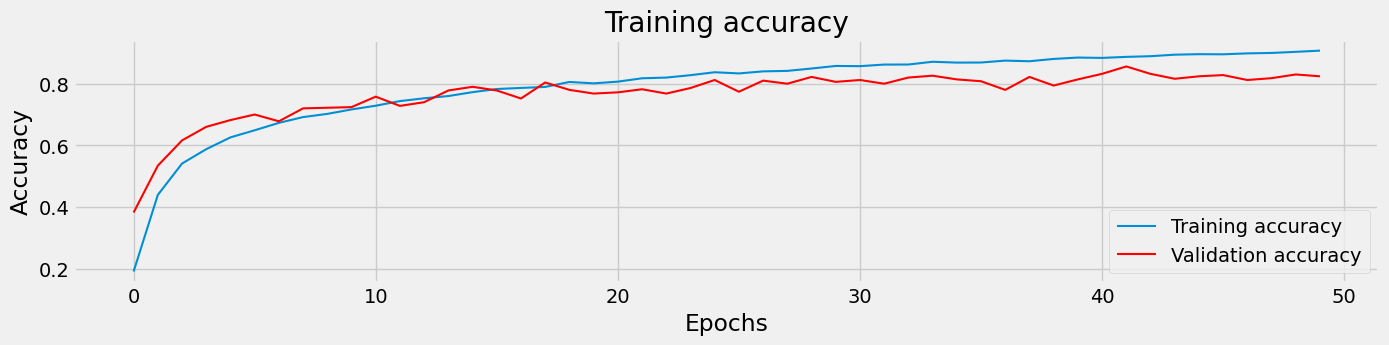

<Figure size 640x480 with 0 Axes>

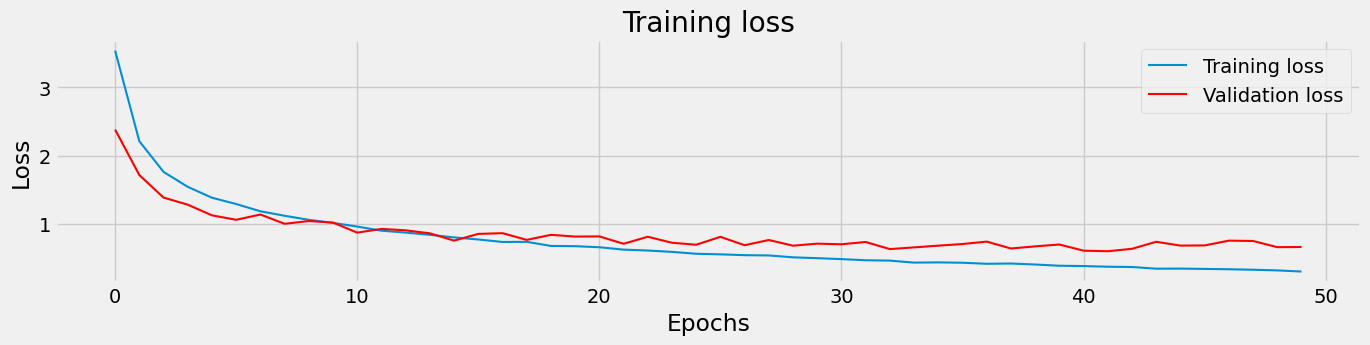

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.style.use('fivethirtyeight')
plot_acc(vgg_history)
plot_loss(vgg_history)
plt.style.use('default')

# Using models to predict bird classes in photographs

## Defining a function that displays 4 images of the predicted bird class

In [ ]:
def plot_images_from_class(target_dir, pred):
  
    """
    takes the directory and prediction as input and prints 4 random images from the targeted class.
    """

    target_class=classes[np.argmax(pred)]
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),4)
 
    plt.figure(figsize=(16,5))
    for i in range(4):
        
        plt.subplot(1,4,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}')
        plt.axis(False)

## Defining a function that predicts the bird classes on 6 images of our test set

In [ ]:
def predict_from_dir(dir):
  images, labels = dir.next()
  preds_base = model.predict(images)
  fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(15,15))
  dic={i:ax for i,ax in enumerate(axes.flat)}
  for i in range(0,6):
      label = np.argmax(labels[i])
      pred = np.argmax(preds_base[i])
      image = images[i]
      dic[i].set_title("real label: " + str(classes[label]) + "\npredictedd label: " + str(classes[pred]))
      dic[i].imshow(image.astype(np.uint8))   
  plt.show()

## Predictions

### From an image passed to our first model

La classe de l'oiseau sur l'image passé avec le modèle de base est:  ALBATROSS avec une probabilité de 84.79 %



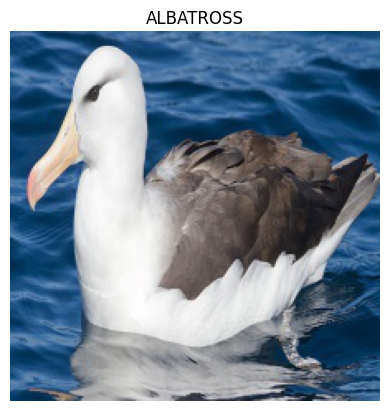

In [ ]:
img = image.load_img("/content/drive/MyDrive/test_db_100/images_to_test/133.jpg", target_size=(224,224))
x = image.img_to_array(img)

# Expand the image's shape to 4 dimensions

x = np.expand_dims(x,axis=0)
pred_base = model.predict(x)

# Prediction probability

probability_base = round(np.max(model.predict(x)*100),2)

print("La classe de l'oiseau sur l'image passé avec le modèle de base est: ", classes[np.argmax(pred_base)], "avec une probabilité de", probability_base, "%\n")

plt.title(classes[np.argmax(pred_base)])
plt.axis(False)
plt.imshow(img);

Displaying some images of the predicted class

Voici quelques images de la classe ALBATROSS :



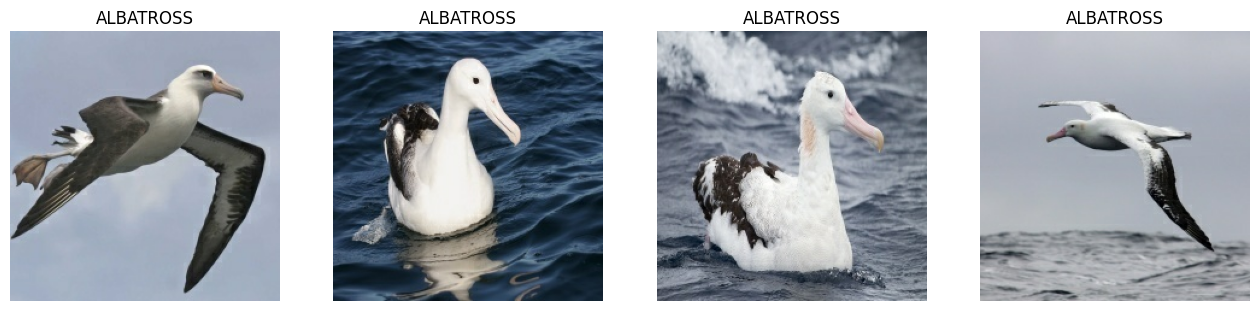

In [ ]:
print("Voici quelques images de la classe", classes[np.argmax(pred_base)], ":\n")
plot_images_from_class(DIR_TEST)

### From an image passed to our second model

La classe de l'oiseau sur l'image passé avec le modèle vgg est:  ANDEAN LAPWING avec une probabilité de 100.0 %



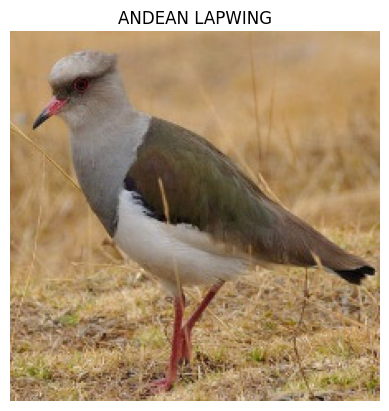

In [ ]:
img = image.load_img("/content/drive/MyDrive/test_db_100/images_to_test/144.jpg", target_size=(224,224))
x = image.img_to_array(img)

# Expand the image's shape to 4 dimensions

x = np.expand_dims(x,axis=0)

pred_vgg = vgg_model.predict(x)

# Prediction probability

probability_vgg = round(np.max(vgg_model.predict(x)*100),2)

print("La classe de l'oiseau sur l'image passé avec le modèle vgg est: ", classes[np.argmax(pred_vgg)], "avec une probabilité de", probability_vgg, "%\n")

plt.title(classes[np.argmax(pred_vgg)])
plt.axis(False)
plt.imshow(img);

Voici quelques images de la classe ANDEAN LAPWING :



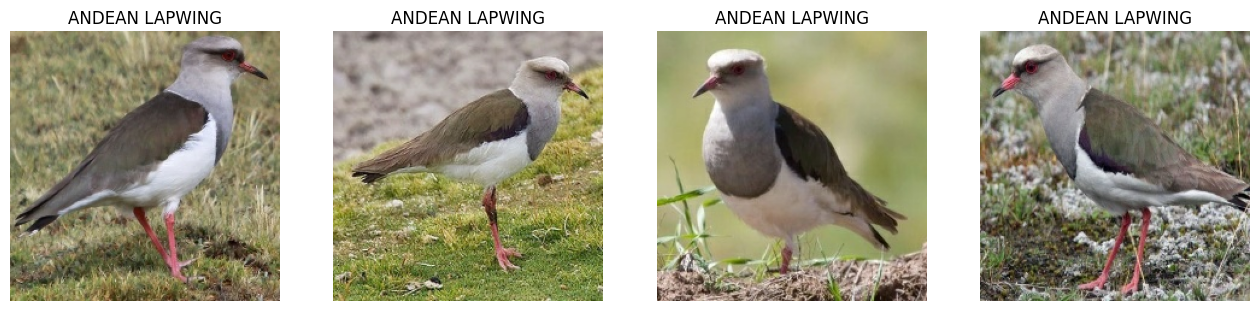

In [ ]:
print("Voici quelques images de la classe", classes[np.argmax(pred_vgg)], ":\n")
plot_images_from_class(DIR_TEST, pred_vgg)

### From our test set

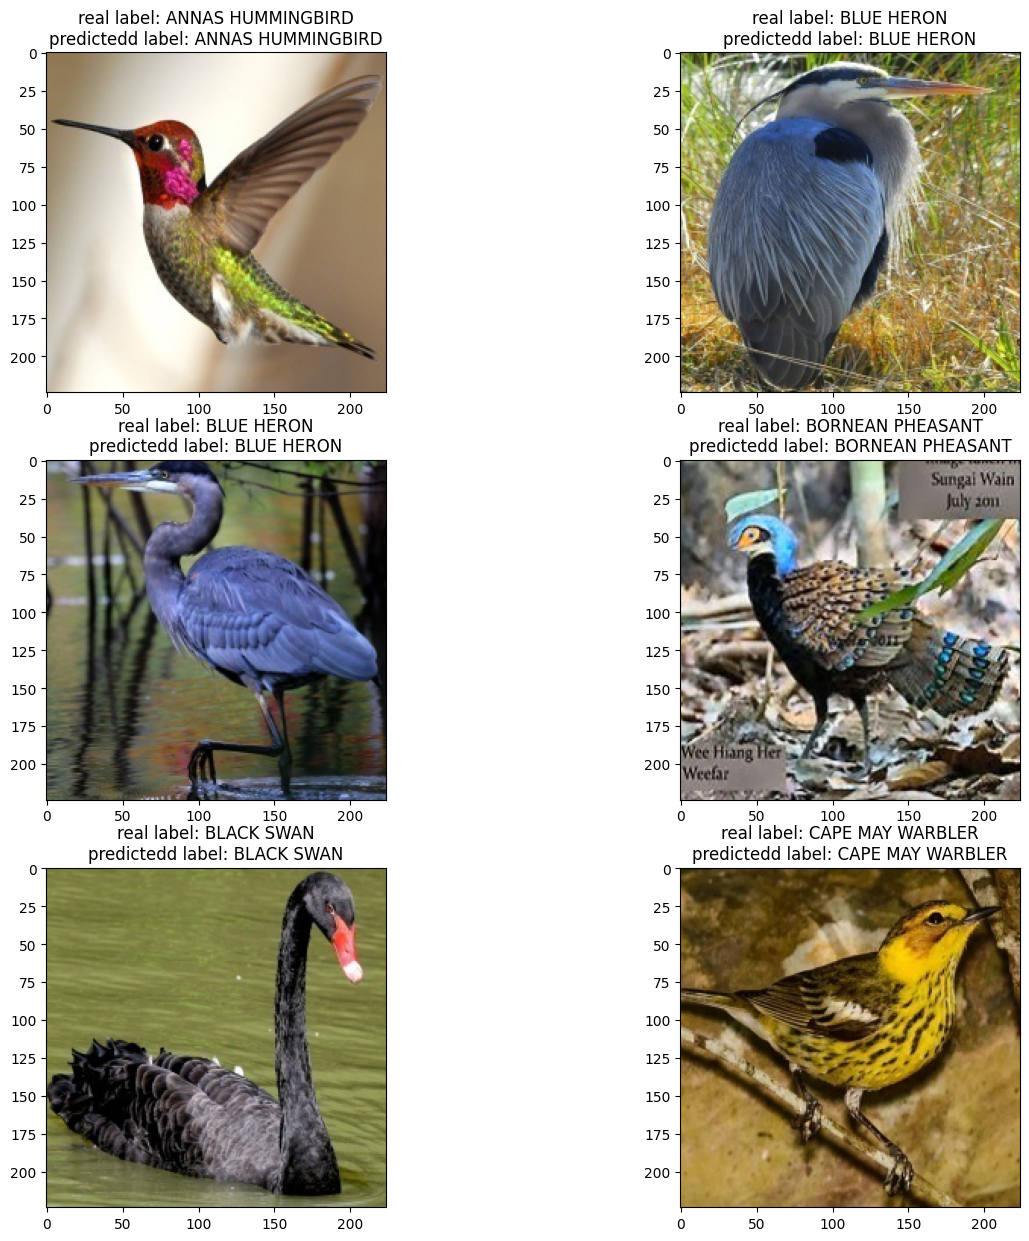

In [ ]:
predict_from_dir(test_ds)

# Conclusion

The first training model performed exceptionally well on the data set without assistance. After some performance adjustments, it continued to improve its accuracy.

The second model based on the VGG16 architecture also performed very well on our data set. However, there were tradeoffs in performance versus speed. We concluded that we could perhaps continue to improve the model by a fraction of a percent with each new implementation of the model, but each run took **1** to **2** hours. Usually, this would have been fine, but waiting for the results certainly impacted the ability to be nimble in the adjustments.

With a final accuracy of **75%** on the test set for the first base model and **92%** on the second based on the VGG16 architecture, we are pretty pleased with this work and the performance of these two models.